# Trying to get something e2e

In [1]:
import cv2
import numpy as np
import keras
import sudoku
from matplotlib import pyplot as plt
from math import ceil

2024-06-06 19:43:50.231031: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-06 19:43:50.265417: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-06-06 19:43:51.821338: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 19:43:51.827244: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 19:43:51.827267: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 19:43:51.829967: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 19:43:51.829992: I external/local_xla/xla/stream_executor

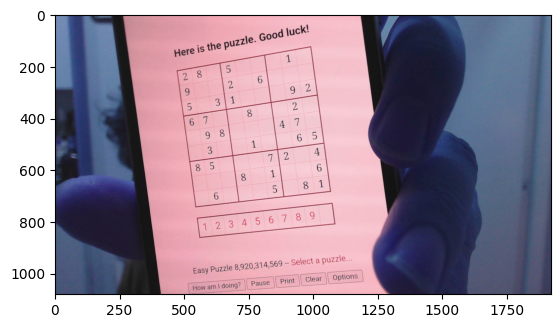

In [2]:
# image = cv2.imread(f"./sudoku_images/image1078.jpg")
image = cv2.imread(f"./images/15.jpg")

digit_model = keras.models.load_model('models/digits_9957_0146_1717662260.keras')
orientation_model = keras.models.load_model('models/orientations_8953_2279_1717662653.keras')

plt.imshow(image)

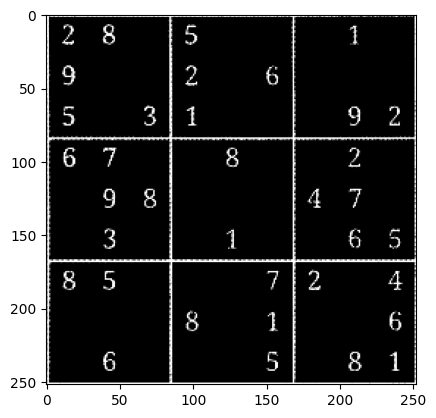

In [3]:
def convert_to_binary(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    otsu = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
    adapt_g = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,3,3)
    adapt_m = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,9,7)
    
    # plt.figure(figsize = (30,30))
    # plt.imshow(np.hstack([gray, otsu, adapt_g, adapt_m]), cmap='grey')
    return otsu
    # return cv2.threshold(gray,120,255,cv2.THRESH_BINARY_INV)[1]


def get_quads(cnts, arc_length_threshold=0.1):
    approxed = [
        cv2.approxPolyDP(
            cnt,
            arc_length_threshold*cv2.arcLength(cnt,True),
            True,
        )
        for cnt in cnts      
    ]
    return [c for c in approxed if len(c) == 4]


def distance_from_center(img, cnt):
    M = cv2.moments(cnt)
    if M['m00'] == 0:
        return (float('inf'), float('inf'))
        
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    height, width = img.shape
    return (
        abs(cx - (width / 2)),
        abs(cy - (height / 2)),
    )


def near_center(img, cnts, max_distance=0.25):
    for cnt in cnts:
        dx, dy = distance_from_center(img, cnt)
        height, width = img.shape
        if dx / width > max_distance or dy / height > max_distance:
            continue
        yield cnt


# Using this to ensure we pass points to the morph function with a consistent ordering
def sort_points(p):
    points = [point[0] for point in p]
    points = sorted(points, key=lambda p: p[1])
    
    top_points = points[:2]
    bottom_points = points[2:]
    
    top_points = sorted(top_points, key=lambda p: p[0])
    top_left = top_points[0]
    top_right = top_points[1]

    bottom_points = sorted(bottom_points, key=lambda p: p[0])
    bottom_left = bottom_points[0]
    bottom_right = bottom_points[1]
    
    return [top_left, top_right, bottom_left, bottom_right]


# This assumes the Sudoku grid is the largest quad around the center of the image.
# There's another obvious thing to consider which is the aspect ratio of the quad
# (e.g. Is it a square and not a rectangle, but this is working for now)
# Could probably do some testing to see which operations are more expensive
# and tweak ordering
def get_sudoku_corners(img):
    cnts = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
    central_quads = get_quads(near_center(img, cnts))
    largest_central = max(central_quads, key=lambda c: abs(cv2.contourArea(c)))
    return np.float32(sort_points(largest_central))


def get_image_region(img, sorted_points, size=252):
    target = np.float32([
        [0,0],
        [size,0],
        [0,size],
        [size,size],
    ])
    transform = cv2.getPerspectiveTransform(sorted_points, target)
    return cv2.warpPerspective(img, transform, (size,size))


binary = convert_to_binary(image)
corners = get_sudoku_corners(binary)
sudoku_grid_img = get_image_region(binary, corners)

plt.imshow(sudoku_grid_img, cmap='gray')

I0000 00:00:1717703032.783840    2304 service.cc:145] XLA service 0x7f12e8004cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717703032.783879    2304 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-06-06 19:43:52.789188: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-06 19:43:52.820226: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step


I0000 00:00:1717703033.103311    2304 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2 8 0 | 5 0 0 | 0 1 0 | 
9 0 0 | 2 0 6 | 0 0 0 | 
5 0 3 | 1 0 0 | 0 9 2 | 
------|-------|-------|-
6 7 0 | 0 8 0 | 0 2 0 | 
0 9 8 | 0 0 0 | 4 7 0 | 
0 3 0 | 0 1 0 | 0 6 5 | 
------|-------|-------|-
8 5 0 | 0 0 7 | 2 0 4 | 
0 0 0 | 8 0 1 | 0 0 6 | 
0 6 0 | 0 0 5 | 0 8 1 | 
------|-------|-------|-


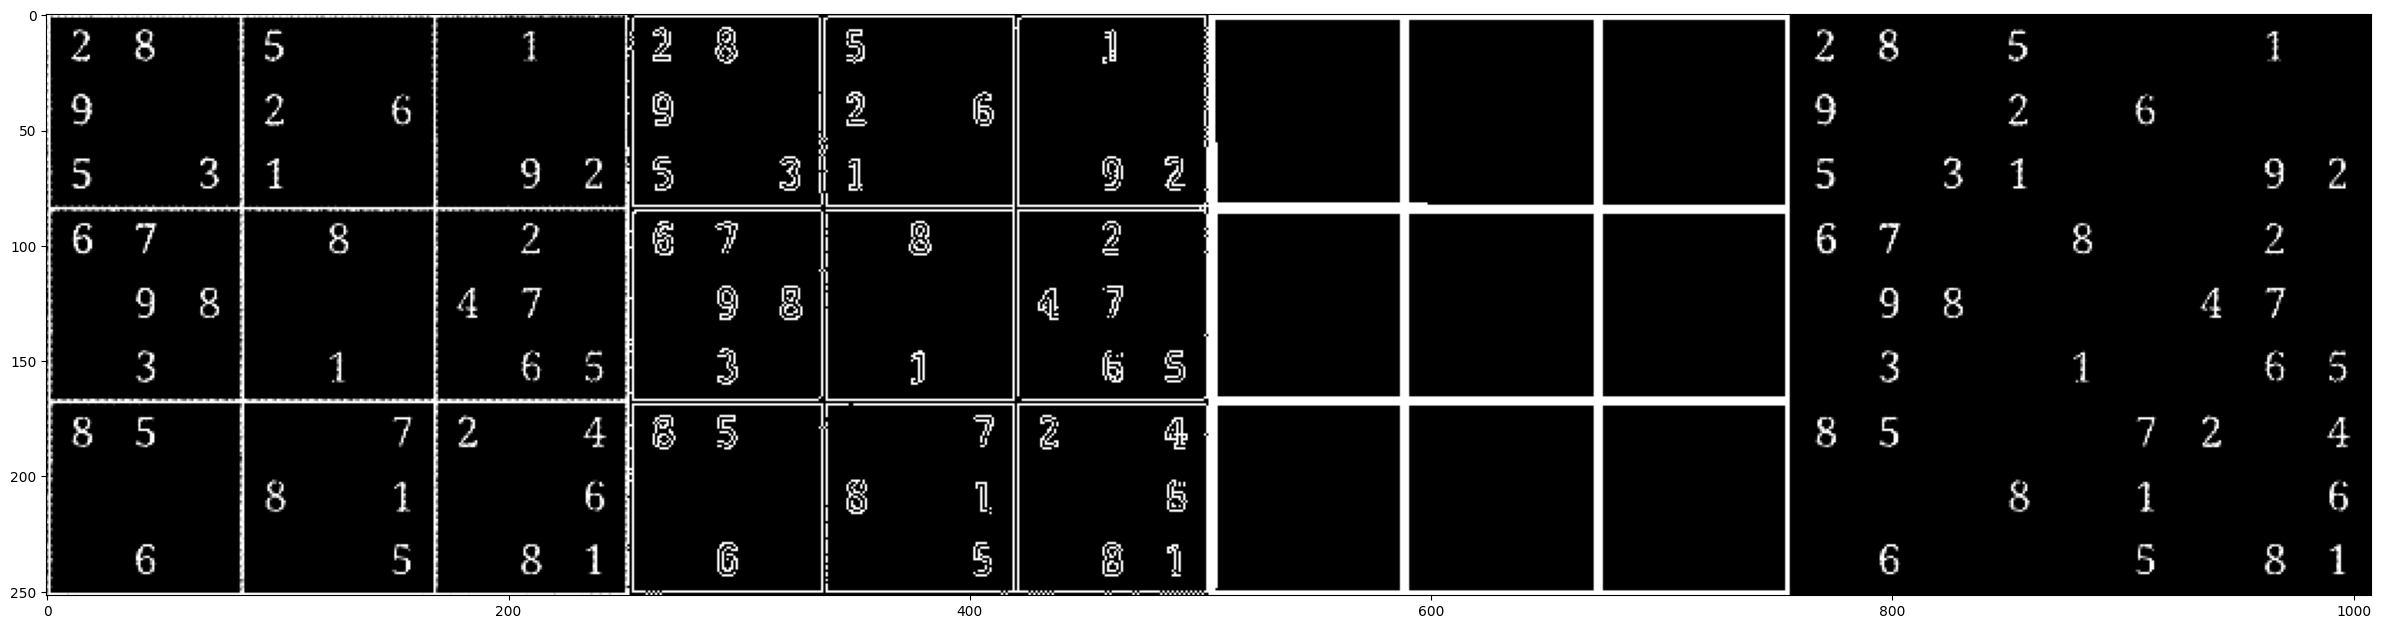

In [4]:
def clean_grid(img):
    edges = cv2.Canny(img,50,150,apertureSize = 3)
    height, width = img.shape
    lines = cv2.HoughLinesP(img,1,np.pi/2,50,minLineLength=60,maxLineGap=5)
    mask = np.zeros((height, width), dtype=np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(mask,(x1,y1),(x2,y2),(255,0,0),2)
    removed = cv2.bitwise_and(img, np.invert(mask))
    # cleaned = cv2.morphologyEx(removed, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)), iterations=1)
    plt.figure(figsize = (30,30))
    plt.imshow(np.hstack([img, edges, mask, removed]), cmap='grey')
    return removed

def get_cells(img):
    height, width = img.shape
    return np.array([np.hsplit(c, 9) for c in np.vsplit(img, 9)]).reshape(-1, height//9, width//9)


def predict_orientation(cells, min_conf=0.6):
    orientation_result = orientation_model.predict(np.array(cells).reshape(-1, 28, 28, 1))
    orientation_prediction = np.argmax(orientation_result, axis=1)
    result = np.apply_along_axis(lambda v: np.argmax(v) if np.amax(v) >= min_conf else -1, 1, orientation_result)
    values, counts = np.unique([r for r in result if r > -1], return_counts=True)
    return values[np.argmax(counts)]


def predict_digits(cells, min_conf=0.9):
    digit_result = digit_model.predict(np.array(cells).reshape(-1, 28, 28, 1))
    result = np.apply_along_axis(lambda v: np.argmax(v) if np.amax(v) >= min_conf else 0, 1, digit_result)
    return result

cleaned = clean_grid(sudoku_grid_img)
cells = get_cells(cleaned)

orientation = predict_orientation(cells)
fix_rotation = [None, cv2.ROTATE_90_CLOCKWISE,cv2.ROTATE_180,cv2.ROTATE_90_COUNTERCLOCKWISE][orientation]
if fix_rotation is not None:
    cells = get_cells(cv2.rotate(cleaned, fix_rotation))
digits = predict_digits(cells).reshape(9, 9)

for r, row in enumerate(digits):
    for c, v in enumerate(row):
        print(f"{v} " if v is not None else "  ", end="")
        if (c+1) % 3 == 0:
            print("| ", end="")
    print("")
    if (r+1) % 3 == 0:
        print(f"{'-'*6}|-"*3)

2 8 6 | 5 9 4 | 3 1 7 | 
9 1 7 | 2 3 6 | 5 4 8 | 
5 4 3 | 1 7 8 | 6 9 2 | 
------|-------|-------|-
6 7 5 | 4 8 3 | 1 2 9 | 
1 9 8 | 6 5 2 | 4 7 3 | 
4 3 2 | 7 1 9 | 8 6 5 | 
------|-------|-------|-
8 5 1 | 9 6 7 | 2 3 4 | 
3 2 9 | 8 4 1 | 7 5 6 | 
7 6 4 | 3 2 5 | 9 8 1 | 
------|-------|-------|-


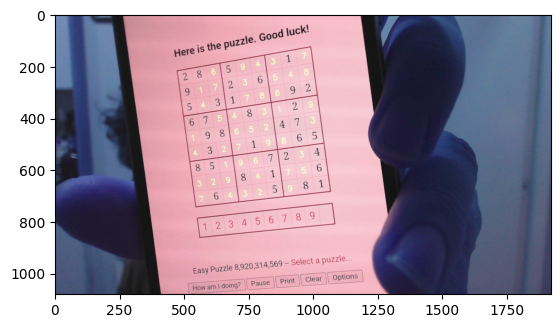

In [5]:
def get_solution_mask(solution, size=700, inset=26):
    cell_size = size / 9
    if solution is None:
        return np.full((size, size, 4), [0, 0, 255, 127], dtype=np.uint8)
    mask = np.zeros((size, size, 4), dtype=np.uint8)
    for y, row in enumerate(solution):
        for x, val in enumerate(row):
            point = (
                int(x * cell_size + inset),
                int(y * cell_size + cell_size - inset),
            )
            if val["locked"]:
                continue
            cv2.putText(
                mask,
                str(val["value"]),
                point,
                cv2.FONT_HERSHEY_SIMPLEX,
                1.25,
                (0, 255, 0, 255) if not val["locked"] else (0, 0, 255, 255),
                2,
                cv2.LINE_AA
            )
    return mask
    

def undo_transform(img, rotation, sorted_points, initial_image):
    img_height, img_width, _ = img.shape
    initial_height, initial_width, _ = initial_image.shape
    if rotation is not None:
        img = cv2.rotate(img, {
            cv2.ROTATE_90_CLOCKWISE: cv2.ROTATE_90_COUNTERCLOCKWISE,
            cv2.ROTATE_180: cv2.ROTATE_180,
            cv2.ROTATE_90_COUNTERCLOCKWISE: cv2.ROTATE_90_CLOCKWISE,
        }[rotation])

    transform = cv2.getPerspectiveTransform(
        np.float32([
            [0,0],
            [img_width, 0],
            [0, img_height],
            [img_width, img_height],
        ]),
        sorted_points,
    )
    return cv2.warpPerspective(img, transform, (initial_width, initial_height))


def overlay(image, digits):
    image_alpha = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)
    return cv2.addWeighted(digits, 1, image_alpha, 1, 0)
    
solution = None
try:
    solution = sudoku.solve(digits)
    for r, row in enumerate(solution):
        for c, v in enumerate(row):
            print(f"{v['value']} " if v is not None else "  ", end="")
            if (c+1) % 3 == 0:
                print("| ", end="")
        print("")
        if (r+1) % 3 == 0:
            print(f"{'-'*6}|-"*3)
except ValueError as e:
    print(e)
    solution = None

mask = get_solution_mask(solution)
positioned_mask = undo_transform(mask, fix_rotation, corners, image)
result = overlay(image, positioned_mask)

plt.imshow(result)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


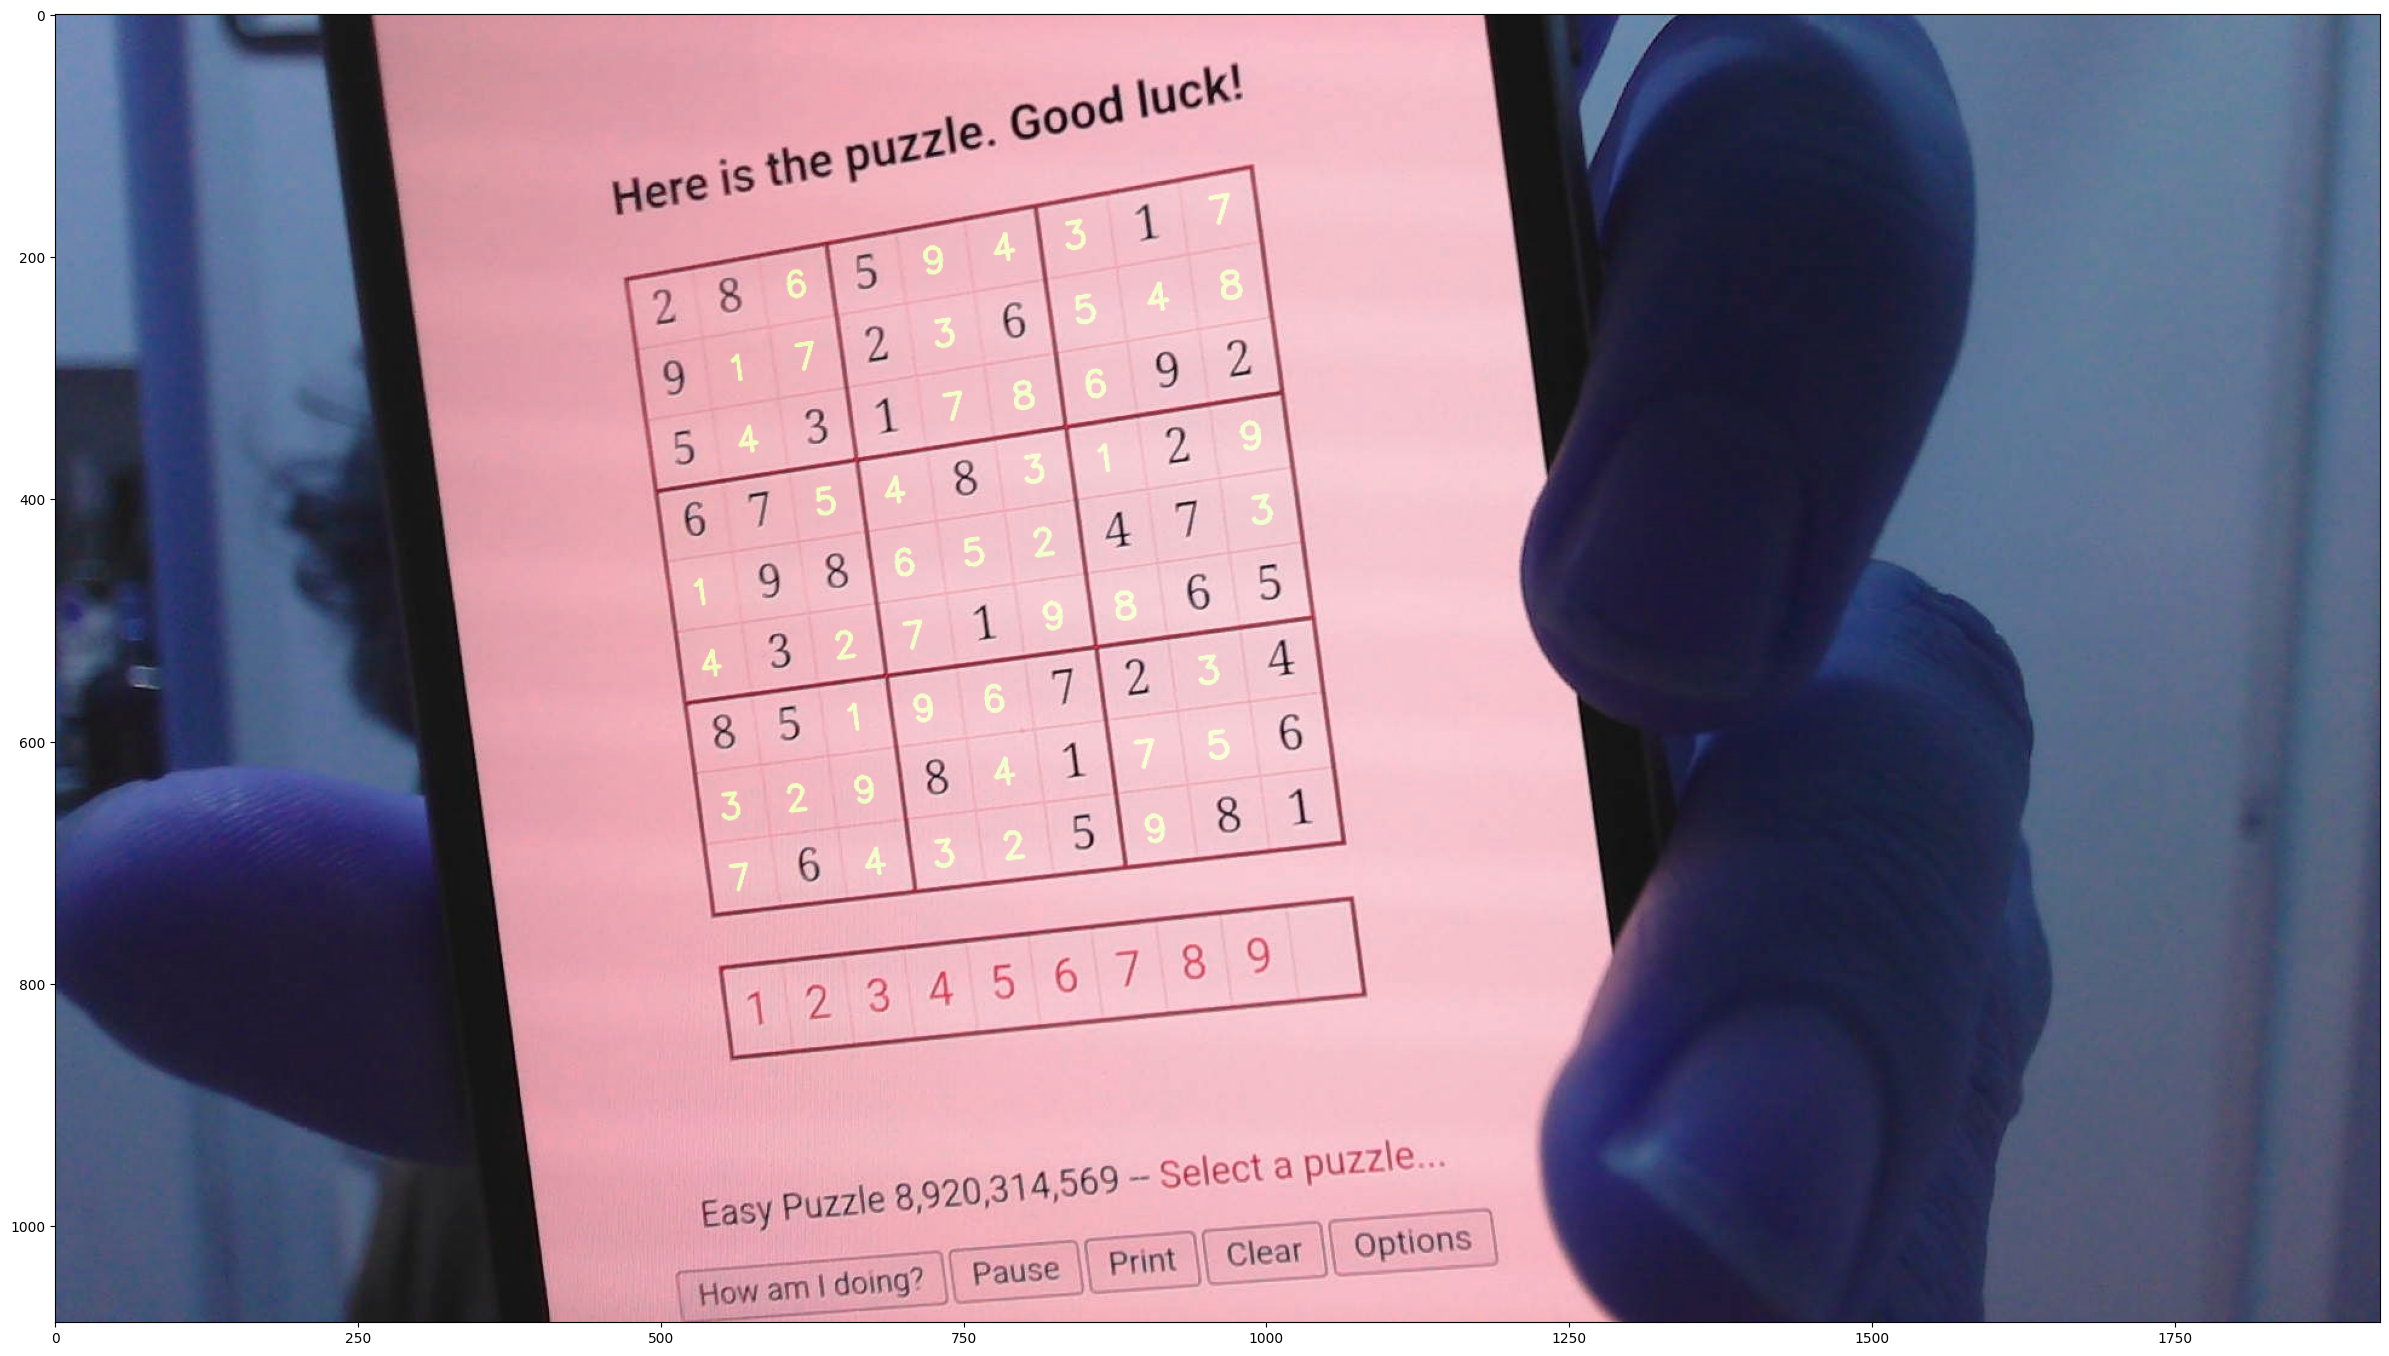

In [6]:
# Putting it all together
def overlay_solution(img):
    binary = convert_to_binary(img)
    corners = get_sudoku_corners(binary)
    sudoku_grid_img = get_image_region(binary, corners)
    cleaned = clean_grid(sudoku_grid_img)
    
    cells = get_cells(cleaned)
    orientation = predict_orientation(cells)
    fix_rotation = [None, cv2.ROTATE_90_CLOCKWISE,cv2.ROTATE_180,cv2.ROTATE_90_COUNTERCLOCKWISE][orientation]
    if fix_rotation is not None:
        cells = get_cells(cv2.rotate(cleaned, fix_rotation))
    digits = predict_digits(cells).reshape(9, 9)

    solution = None
    try:
        solution = sudoku.solve(digits)
    except ValueError as e:
        solution = None
    
    mask = get_solution_mask(solution)
    positioned_mask = undo_transform(mask, fix_rotation, corners, img)
    return overlay(img, positioned_mask)

plt.imshow(overlay_solution(image))